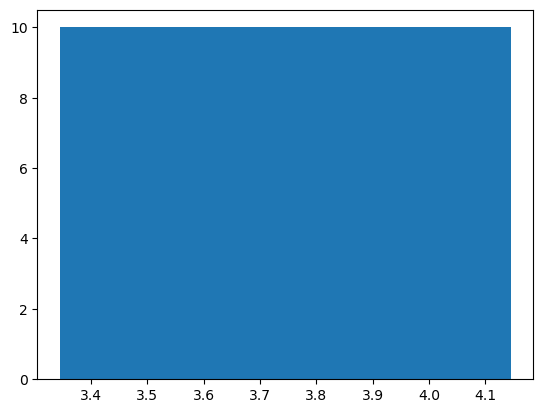

[3.74540119 9.50714306] [1.]


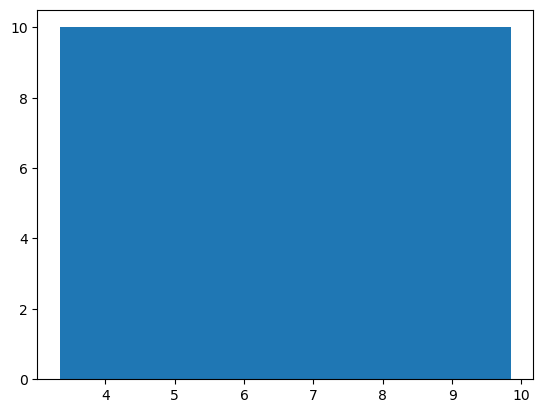

Incremental distortion = 1.920581
Ground-truth distortion= 1.920581
Resampled Incremental distortion = 0.100061
Resampled Ground-truth distortion= 0.100061
Match1 True
Match2 False
Match3 False
Match4 True


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def update_distortion_state(old_state, weight, midpoint, interval_len):
    x, y, z, w, v = old_state

    x_new = x + 2.0 * weight * midpoint * z
    y_new = y + 2.0 * weight * w
    z_new = z + weight
    w_new = w + weight * midpoint
    v_new = v + (weight * weight) * (interval_len / 3.0)

    return np.array([x_new, y_new, z_new, w_new, v_new])

def incremental_distortion(t, w):
    """
    Compute the full distortion using the incremental approach,
    accumulating both cross-interval and intra-interval terms in one pass.

    Args:
      t: array of shape (N+1,) for interval boundaries
      w: array of shape (N,) for weights
    Returns:
      distortion: scalar = sum_{i,j} w_i w_j |m_i - m_j| + (1/3)*sum_i [w_i^2 * (t_{i+1}-t_i)]
    """
    # Midpoints
    midpoints = 0.5 * (t[:-1] + t[1:])
    intervals = (t[1:] - t[:-1])

    # Initialize the state = [x, y, z, w, v].
    state = np.zeros(5, dtype=np.float32)

    # Accumulate
    for i in range(len(w)):
        state = update_distortion_state(state, w[i], midpoints[i], intervals[i])
        # print(i, state)

    # Unpack final state
    x, y, _, _, v = state
    # Cross-interval portion = (x - y)
    # Intra-interval portion = v
    return (x - y) + v

def distortion_ground_truth(t, w):
    """
    The direct (JAX-like) distortion computation:
      sum_{i,j} w_i w_j |(t_i+t_{i+1})/2 - (t_j+t_{j+1})/2| + sum_i [ w_i^2 (t_{i+1}-t_i)/3 ].
    Implemented in NumPy for testing.
    """
    # Midpoints of intervals:
    ut = 0.5 * (t[:-1] + t[1:])
    # Pairwise absolute differences of midpoints:
    diff = np.abs(ut[:, None] - ut[None, :])
    # sum_{i,j} w_i w_j |m_i - m_j|
    pairwise = np.sum(w * np.sum(w[:, None] * diff, axis=0))
    # sum_i [w_i^2 (t_{i+1}-t_i)/3]
    intra = np.sum(w**2 * (t[1:] - t[:-1])) / 3.0
    return pairwise + intra

def log1mexp(x):
    """Accurate computation of log(1 - exp(-x)) for x > 0, thanks watsondaniel."""
    # https://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf
    return np.where(x > np.log(2), np.log1p(-np.exp(-x)), np.log(-np.expm1(-x)))


def compute_alpha_weights_helper(density_delta):
    log_trans = -np.concatenate(
        [
            np.zeros_like(density_delta[..., :1]),
            np.cumsum(density_delta[..., :-1], axis=-1),
        ],
        axis=-1,
    )

    log_weights = log1mexp(density_delta) + log_trans
    weights = np.exp(log_weights)
    return weights

# ---------------------------------------------------------------------
#  Test the two implementations on random inputs:
# ---------------------------------------------------------------------
np.random.seed(42)

def piecewise_constant_function(t, w, x):
    t = np.asarray(t, dtype=np.float32)
    w = np.asarray(w, dtype=np.float32)
    x = np.asarray(x, dtype=np.float32)
    indices = np.searchsorted(t, x, side='right') - 1
    indices = np.clip(indices, 0, len(w) - 1)
    return w[indices]

for _ in range(1):
    # Random number of intervals, each with random boundaries and random weights
    # N = np.random.randint(15, 20)
    N = 1
    ft = np.sort(10*np.random.rand(N+1))  # sorted boundaries
    sigma = np.array([10])#np.random.rand(N)

    t = ft
    dt = t[1:] - t[:-1]
    s1 = piecewise_constant_function(ft, sigma, t[:-1])
    w = compute_alpha_weights_helper(s1 * dt)
    plt.bar(t[:-1], s1)
    plt.show()

    print(t, w)
    val_inc = incremental_distortion(t, w)
    val_gt  = distortion_ground_truth(t, w)

    # print(f"\nN={N}, t={t}, w={w}")
    # print(f"Incremental distortion = {val_inc:.6f}")
    # print(f"Ground-truth distortion= {val_gt:.6f}")
    # print("Match?", np.allclose(val_inc, val_gt, rtol=1e-6, atol=1e-8))

    t2 = np.linspace(t.min(), t.max(), 100)
    dt2 = t2[1:] - t2[:-1]
    s2 = piecewise_constant_function(ft, sigma, t2[:-1])
    w2 = compute_alpha_weights_helper(s2 * dt2)
    val_inc2 = incremental_distortion(t2, w2)
    val_gt2  = distortion_ground_truth(t2, w2)
    plt.bar(t2[:-1], s2)
    plt.show()

    # print(f"\nN={N}, t={t}, w={w}")
    print(f"Incremental distortion = {val_inc:.6f}")
    print(f"Ground-truth distortion= {val_gt:.6f}")
    print(f"Resampled Incremental distortion = {val_inc2:.6f}")
    print(f"Resampled Ground-truth distortion= {val_gt2:.6f}")

In [ ]:
def moment_0_int(a, b, s1):
    return (1 - np.exp(s1*(a - b)))/s1
def moment_1_int(a, b, s1):
    return (a*s1 - (b*s1 + 1)*np.exp(s1*(a - b)) + 1)/s1**2

def self_dist(a, b, s):
    ds = s * (a-b)
    return (2 * s * (a-b) * np.exp(ds) + 1 - np.exp(2*ds)) / s**3

def cross_distortion(t, sigma):
    """
    t: array of boundaries [t0, t1, ..., tN]
    sigma: array of length N of constant densities on each slab
    Intervals are non-overlapping and in ascending order. 
    """
    N = len(sigma)

    # 1) Precompute M0(i), M1(i), and diagonal dist
    M0_array = np.empty(N, dtype=float)
    M1_array = np.empty(N, dtype=float)
    diag_array = np.empty(N, dtype=float)
    T_array = np.empty(N, dtype=float)
    T = 1

    for i in range(N):
        t1, t2 = t[i], t[i+1]
        M0_array[i] = T*moment_0_int(t1, t2, sigma[i])
        M1_array[i] = T*moment_1_int(t1, t2, sigma[i])
        diag_array[i] = T*T*self_dist(t1, t2, sigma[i])
        T_array[i] = T
        alpha = 1-np.exp(-sigma[i]*(t2-t1))
        T = T * (1-alpha)
    # print(T_array)

    # 2) Accumulate cross-dist using prefix sums
    cross_dist = 0.0
    for j in range(N):
        for i in range(j):
            cross_dist += M1_array[j]*M0_array[i] - M0_array[j]*M1_array[i]

    # 3) Sum diagonal
    diag_dist = diag_array.sum()
    # print(diag_array, cross_dist)

    return 2*cross_dist + diag_dist

N = 1
ft = np.sort(10*np.random.rand(N+1))  # sorted boundaries
sigma = np.random.rand(N)
print('cd1:', cross_distortion(ft, sigma))

t2 = np.linspace(ft.min(), ft.max(), 200)
dt2 = t2[1:] - t2[:-1]
# print(ft, t2)
s2 = piecewise_constant_function(ft, sigma, t2[:-1])
# print(sigma, s2)

print('cd2:', cross_distortion(t2, s2))
print(self_dist(ft.min(), ft.max(), sigma))

cd1: 0.43533677101458923
cd2: 0.43533675397329163
[0.43533677]


In [ ]:
def update_distortion_state_int(state, t1, t2, sigma):
    x, y, z, w, v, T = state
    m0 = T*moment_0_int(t1, t2, sigma)
    m1 = T*moment_1_int(t1, t2, sigma)
    new_z = z + m0
    new_w = w + m1
    new_x = x + z * m1
    new_y = y + w * m0
    new_v = v + T*T*self_dist(t1, t2, sigma)
    alpha = 1-np.exp(-sigma*(t2-t1))
    new_T = T * (1-alpha)
    return np.array([new_x, new_y, new_z, new_w, new_v, new_T])

def incremental_distortion(t, sigma):
    state = np.zeros(6, dtype=np.float32)
    state[-1] = 1
    for i in range(len(sigma)):
        state = update_distortion_state_int(state, t[i], t[i+1], sigma[i])
    x, y, _, _, v, _ = state
    return 2*(x - y) + v

# N = 1
# ft = np.sort(10*np.random.rand(N+1))  # sorted boundaries
# sigma = np.random.rand(N)
print(incremental_distortion(ft, sigma))
print(cross_distortion(ft, sigma))

print('id:', incremental_distortion(t2, s2))
print('cd:', cross_distortion(t2, s2))


0.43533677101458923
0.43533677101458923
id: 0.43533675397328525
cd: 0.43533675397329163


In [58]:
import numpy as np
def f(x, y, a, b, s):
    return np.exp(-s * (x-a)) * np.exp(-s * (y-a)) * np.abs(x-y)

def f2(x, y, a, b, s):
    return 2*np.exp(-s * (x-a)) * np.exp(-s * (y-a)) * (x-y)

def double_integral(a, b, s, num_points=200):
    """
    Numerically approximate the double integral of f(x, y, a, b, s)
    over x, y in [a, b] using a 2D Riemann sum.
    
    Parameters:
    -----------
      a          : float, lower limit of integration
      b          : float, upper limit of integration
      s          : float, parameter for the integrand
      num_points : int, number of points along each dimension for the Riemann sum

    Returns:
    --------
      result : float, approximate value of the double integral
    """
    
    # Create 1D arrays of x and y values
    x_values = np.linspace(a, b, num_points)
    y_values = np.linspace(a, b, num_points)

    # Step sizes in x and y
    dx = (b - a) / (num_points - 1)
    dy = (b - a) / (num_points - 1)

    # Create 2D mesh grids for x and y
    X, Y = np.meshgrid(x_values, y_values, indexing='xy')

    # Evaluate f over the mesh
    Z = f(X, Y, a, b, s)
    result1 = Z.sum() * dx * dy
    Z = (X > Y) * f2(X, Y, a, b, s)

    # Compute the Riemann-sum
    result2 = Z.sum() * dx * dy
    return result2

import sympy

# Define symbols
x, y = sympy.symbols('x y', real=True, positive=True)
a_sym, b_sym, s_sym = sympy.symbols('a b s', real=True, positive=True)

# Define the integrand f2(x, y, a, b, s) = 2 * e^{-s(x-a)} * e^{-s(y-a)} * (x - y)
f2_sym = 2 * sympy.exp(-s_sym*(x - a_sym)) * sympy.exp(-s_sym*(y - a_sym)) * (x - y)

# Perform the inner integral w.r.t. y: from y=a to y=x
inner_integral = sympy.integrate(f2_sym, (y, a_sym, x))

# Perform the outer integral w.r.t. x: from x=a to x=b
result = sympy.integrate(inner_integral, (x, a_sym, b_sym))

# Optionally simplify the resulting expression
result_simplified = sympy.simplify(result)

# Print the final symbolic result
print("Symbolic result (unsimplified):", result)
print("Symbolic result (simplified):", result_simplified)

a = 0
b = 3
s = 10
print(double_integral(a, b, s))
print(result_simplified.subs({a_sym: a, b_sym: b, s_sym: s}).evalf())
print(self_dist(a, b, s))

Symbolic result (unsimplified): s**(-3) + (-s**2*exp(2*a*s)*exp(-2*b*s) + (2*a*s**3*exp(a*s) - 2*b*s**3*exp(a*s))*exp(-b*s))/s**5
Symbolic result (simplified): (2*s*(a - b)*exp(s*(a + 2*b)) + exp(3*b*s) - exp(s*(2*a + b)))*exp(-3*b*s)/s**3
0.0011561266441517367
0.000999999999994385
0.0009999999999943854


In [59]:
def g(x, y, a, b, c, d, s1, s2):
    return 2*np.exp(-s1 * (x-a)) * np.exp(-s2 * (y-c)) * (x-y)

def g_int(a, b, c, d, s1, s2):
    return -(moment_1_int(c, d, s2) * moment_0_int(a, b, s1) - moment_0_int(c, d, s2) * moment_1_int(a, b, s1))

In [68]:
#
# Part B: Symbolically integrate g(x,y) in Sympy to check its closed form
#
x_sym, y_sym = sympy.symbols('x y', real=True)
a_sym, b_sym, c_sym, d_sym = sympy.symbols('a b c d', real=True)
s1_sym, s2_sym = sympy.symbols('s1 s2', real=True, positive=True)

# Define the integrand in Sympy:
g_expr = 2*sympy.exp(-s1_sym*(x_sym-a_sym)) * sympy.exp(-s2_sym*(y_sym - c_sym)) * (x_sym - y_sym)

# Symbolic double integral: ∫(x=a..b) ∫(y=c..d) g_expr dy dx
inner_int = sympy.integrate(g_expr, (y_sym, c_sym, d_sym))
sym_result = sympy.integrate(inner_int, (x_sym, a_sym, b_sym))
sym_result_simplified = sympy.simplify(sym_result)

#
# Part C: Numeric 2D integral (Riemann sum) to verify
#
def numeric_double_integral(a, b, c, d, s1, s2, num_points=200):
    """
    Numerically approximate ∫[x=a..b] ∫[y=c..d] g(x,y) dy dx
    using a simple 2D Riemann sum.
    """
    x_vals = np.linspace(a, b, num_points)
    y_vals = np.linspace(c, d, num_points)
    dx = (b - a)/(num_points - 1)
    dy = (d - c)/(num_points - 1)

    total = 0.0
    for xi in x_vals:
        for yi in y_vals:
            total += g(xi, yi, a, b, c, d, s1, s2) * dx * dy
    return total

# Choose some numeric values
a_val, b_val = 0.0, 1.0
c_val, d_val = 2.0, 4.0
s1_val, s2_val = 2.0, 5.0

# 1) Evaluate the symbolic expression
sym_val = sym_result_simplified.subs({
    a_sym: a_val,
    b_sym: b_val,
    c_sym: c_val,
    d_sym: d_val,
    s1_sym: s1_val,
    s2_sym: s2_val
}).evalf()

# 2) Evaluate the closed-form expression g_int(...)
closed_form_val = g_int(a_val, b_val, c_val, d_val, s1_val, s2_val)

# 3) Perform a numerical 2D Riemann sum
num_val = numeric_double_integral(a_val, b_val, c_val, d_val, s1_val, s2_val, num_points=400)

# Print all results to compare
print(f"Sympy Integral       = {sym_val}")
print(f"Closed-form (g_int)  = {closed_form_val}")
print(f"Numeric Approx       = {num_val}")

Sympy Integral       = -0.321022782273521
Closed-form (g_int)  = -0.32102278227352077
Numeric Approx       = -0.32582469710325557


In [67]:
import sympy

# Declare the symbols
x, a, b, s1 = sympy.symbols('x a b s1', positive=True)
y, c, d, s2 = sympy.symbols('y c d s2', positive=True)

# -------------------------------------------------------------------
# 1) Define the four 1D integrals (moments) in Sympy
# -------------------------------------------------------------------

# X0(s1) = ∫[x=a..b] e^{-s1*(x-a)} dx
X0_expr = sympy.integrate(sympy.exp(-s1*(x - a)), (x, a, b))

# X1(s1) = ∫[x=a..b] x e^{-s1*(x-a)} dx
X1_expr = sympy.integrate(x*sympy.exp(-s1*(x - a)), (x, a, b))

# Y0(s2) = ∫[y=c..d] e^{-s2*(y-c)} dy
Y0_expr = sympy.integrate(sympy.exp(-s2*(y - c)), (y, c, d))

# Y1(s2) = ∫[y=c..d] y e^{-s2*(y-c)} dy
Y1_expr = sympy.integrate(y*sympy.exp(-s2*(y - c)), (y, c, d))

# Simplify them
X0_simpl = sympy.simplify(X0_expr)
X1_simpl = sympy.simplify(X1_expr)
Y0_simpl = sympy.simplify(Y0_expr)
Y1_simpl = sympy.simplify(Y1_expr)

print("X0(s1) =", X0_expr, " => simplified:", X0_simpl)
print("X1(s1) =", X1_expr, " => simplified:", X1_simpl)
print("Y0(s2) =", Y0_expr, " => simplified:", Y0_simpl)
print("Y1(s2) =", Y1_expr, " => simplified:", Y1_simpl)

def moment_0_int(a, b, s1):
    return (1 - np.exp(s1*(a - b)))/s1
def moment_1_int(a, b, s1):
    return (a*s1 - (b*s1 + 1)*np.exp(s1*(a - b)) + 1)/s1**2
def g_int(a, b, c, d, s1, s2):
    return -2*(moment_1_int(c, d, s2) * moment_0_int(a, b, s1) - moment_0_int(c, d, s2) * moment_1_int(a, b, s1))
print(X0_simpl.subs({a: a_val, b: b_val, s1: s1_val}), moment_0_int(a_val, b_val, s1_val))

# -------------------------------------------------------------------
# 2) Combine to form the final 2D integral from the factorization
#    2 [ X1(s1)*Y0(s2) - Y1(s2)*X0(s1) ]
# -------------------------------------------------------------------
twoD_expr_factorized = 2*(X1_expr*Y0_expr - Y1_expr*X0_expr)
twoD_simpl_factorized = sympy.simplify(twoD_expr_factorized)

# -------------------------------------------------------------------
# 3) Directly integrate g(x,y) in Sympy to confirm the same result
#    g(x,y) = 2 * e^{-s1(x-a)} * e^{-s2(y-c)} * (x - y)
# -------------------------------------------------------------------
g_expr = 2*sympy.exp(-s1*(x-a))*sympy.exp(-s2*(y-c))*(x - y)
twoD_expr_direct = sympy.integrate(sympy.integrate(g_expr, (y, c, d)), (x, a, b))
twoD_simpl_direct = sympy.simplify(twoD_expr_direct)

print("\n\n== Factorized approach integral ==")
print("Un-simplified:", twoD_expr_factorized)
print("Simplified   :", twoD_simpl_factorized)

print("\n== Direct double integral of g(x,y) ==")
print("Un-simplified:", twoD_expr_direct)
print("Simplified   :", twoD_simpl_direct)

# They should match exactly after Sympy's simplification.
diff_expr = sympy.simplify(twoD_simpl_direct - twoD_simpl_factorized)
print("\nDifference between the two approaches =", diff_expr)




X0(s1) = 1/s1 - exp(-s1*(-a + b))/s1  => simplified: (1 - exp(s1*(a - b)))/s1
X1(s1) = -(-a*s1 - 1)/s1**2 + (-b*s1 - 1)*exp(-s1*(-a + b))/s1**2  => simplified: (a*s1 - (b*s1 + 1)*exp(s1*(a - b)) + 1)/s1**2
Y0(s2) = 1/s2 - exp(-s2*(-c + d))/s2  => simplified: (1 - exp(s2*(c - d)))/s2
Y1(s2) = -(-c*s2 - 1)/s2**2 + (-d*s2 - 1)*exp(-s2*(-c + d))/s2**2  => simplified: (c*s2 - (d*s2 + 1)*exp(s2*(c - d)) + 1)/s2**2
0.432332358381694 0.43233235838169365


== Factorized approach integral ==
Un-simplified: -2*(1/s1 - exp(-s1*(-a + b))/s1)*(-(-c*s2 - 1)/s2**2 + (-d*s2 - 1)*exp(-s2*(-c + d))/s2**2) + 2*(1/s2 - exp(-s2*(-c + d))/s2)*(-(-a*s1 - 1)/s1**2 + (-b*s1 - 1)*exp(-s1*(-a + b))/s1**2)
Simplified   : 2*(-s1*(1 - exp(s1*(a - b)))*(c*s2 - (d*s2 + 1)*exp(s2*(c - d)) + 1) + s2*(1 - exp(s2*(c - d)))*(a*s1 - (b*s1 + 1)*exp(s1*(a - b)) + 1))/(s1**2*s2**2)

== Direct double integral of g(x,y) ==
Un-simplified: -(2*a*s1**9*s2**9*exp(a*s1)*exp(c*s2)*exp(3*d*s2) - 2*a*s1**9*s2**9*exp(a*s1)*exp(4*d*s2) + 